In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['figure.dpi'] = 80
matplotlib.rcParams['figure.figsize'] = [17, 4]
matplotlib.rcParams['axes.grid'] = True

In [2]:
# !pip install --upgrade pip --proxy=https://web-proxy.labs.hpecorp.net:8088

In [2]:
import sys
sys.path.insert(0, '../')

from lib_data import *
from lib_nn_dpe import NN_dpe

In [3]:
load_workspace(vars(), '../data/20190821-051552-mnist_xs')

load_workspace(vars(), '../20200130-100802-mnist_config')

Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, software, c, x, y, mat_contents, finalGconv, g1, g2, linear_factors_conv, xs, acc, result, x1, 
Loaded: xs, new_lin_cor_fc1, new_lin_cor_fc2, lin_cor_conv, finalGfc, finalGconv, weights, 


In [4]:
def weight2conductance2(Mweight):
    Glow  = 2.5e-6
    Ghigh = 100e-6 # corresponding to 1s 
                    # Could be higher than this value for weight values
                    # larger than 1
    
    Gpos = np.ones_like(Mweight) * Glow
    Gpos[Mweight>0] +=  Mweight[Mweight>0] * Ghigh
    
    Gneg = np.ones_like(Mweight) * Glow
    Gneg[Mweight<0] += -Mweight[Mweight<0] * Ghigh
    
    G = np.zeros((Mweight.shape[0], Mweight.shape[1]*2))
    G[:, ::2] = Gpos
    G[:, 1::2] = Gneg
    
    return G

## Construct NN

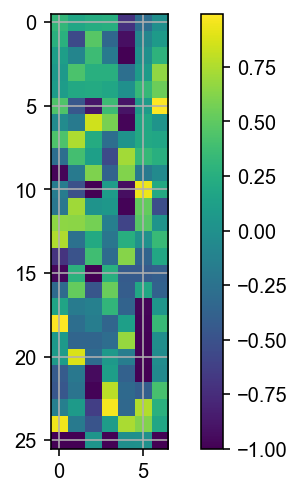

In [5]:
nn = NN_dpe(weights)

plt.imshow(nn.Mconv); plt.colorbar()

## ECC matrix

7 4.0 7.0
The number of redundancy column is chosen to be the smallest even number 8
(26, 15)


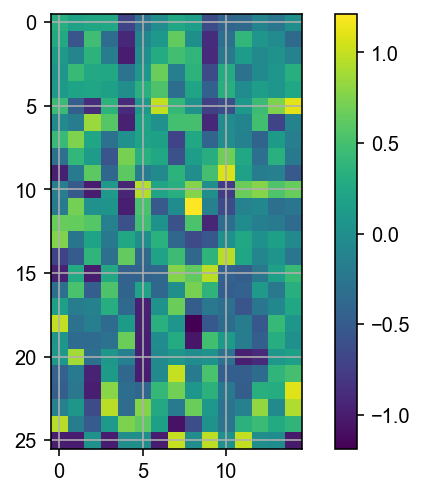

In [6]:
from dpeECC import dpeECC

delta = 1
Delta = 8 * delta

m = nn.Mconv.shape[0]
k = nn.Mconv.shape[1]

print(k, np.ceil(np.sqrt(k+1))+1, 2*k/(np.floor(Delta/(2*delta))-2))

ecc = dpeECC(nn.Mconv, delta, Delta)
M_conv_ecc = ecc.encode()

print('The number of redundancy column is chosen to be the smallest even number', ecc.r)
print(M_conv_ecc.shape)

plt.imshow(M_conv_ecc); plt.colorbar()

Convert to conductance

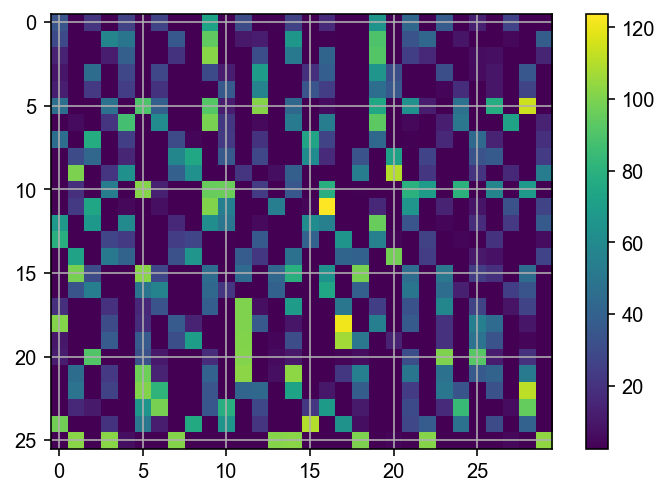

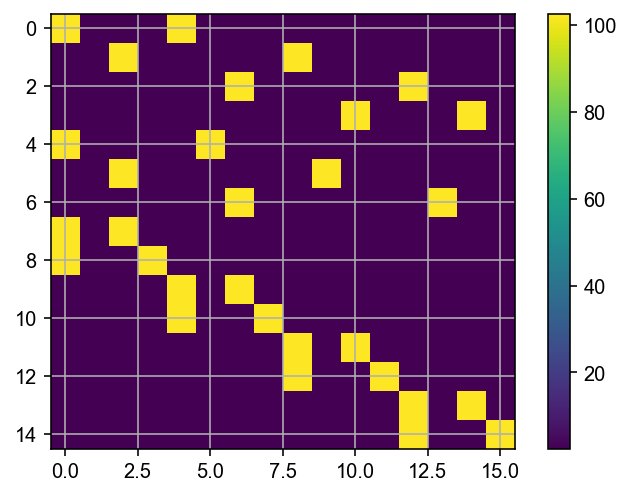

In [7]:
G_conv_ecc = weight2conductance2(M_conv_ecc)
G_parity_ecc = weight2conductance2(ecc.H.T)

plt.figure(1)
plt.imshow(G_conv_ecc * 1e6); plt.colorbar()

plt.figure(2)
plt.imshow(G_parity_ecc * 1e6); plt.colorbar()

## Program the array

In [9]:
from dpe import DPE

dpe = DPE('COM3')
dpe.set_clock(50)

DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz


....

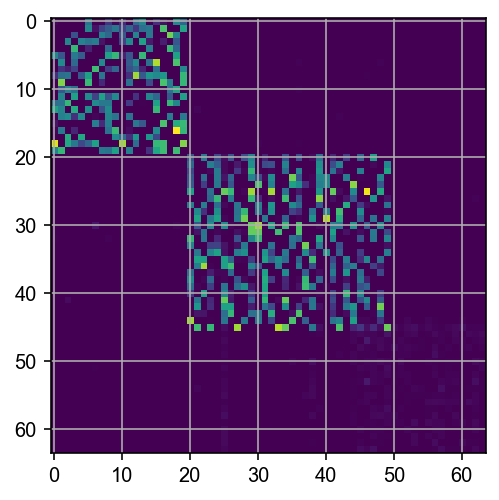

In [10]:
g = dpe.read(0)
plt.imshow(g)

In [11]:
Gtarget = np.zeros((64,64))

Gtarget[20:20+G_conv_ecc.shape[0], 20:20+G_conv_ecc.shape[1]] = G_conv_ecc

Msel = np.zeros((64,64))
Msel[20:,20:] = 1

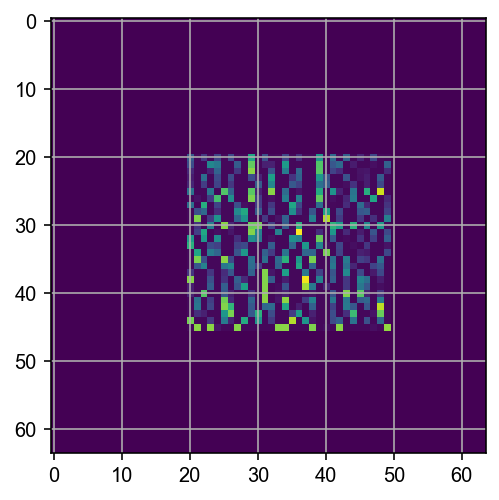

In [12]:
plt.imshow(Gtarget)

In [150]:
data = dpe.tune_conductance(0,  Gtarget, saveHistory=True, maxSteps=300, method='fast',
                           vSetRamp=[1, 3, 0.25], vGateSetRamp=[0.5, 1.4, 0.05],
                           vResetRamp=[0.3, 1.5, 0.05], vGateResetRamp=[5.0, 5.5, 0.5], 
                           Twidth=10e-6, TwidthReset=1e-3,  Msel=Msel, Gtol_in=4e-6, Gtol_out=10e-6, numReads=3)

Start programming, step=220, maxBound=124 yield= 86.11% - 98.45%
1.0 devices to be programmed...reset 118.0, set 7.0
Setting 0 devices...
Programming with external timing Twidth=10.000 us
Resetting 2 devices...
Programming with external timing Twidth=1000.000 us
------------------------------
Programming completed.


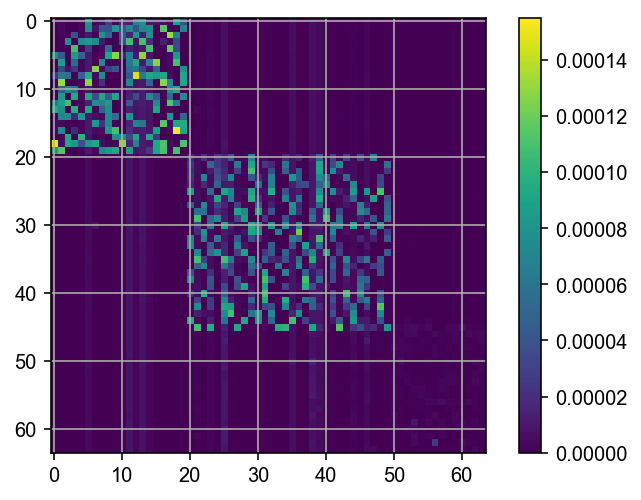

In [15]:
g2 = dpe.read(0, method='fast')
plt.imshow(g2); plt.colorbar()

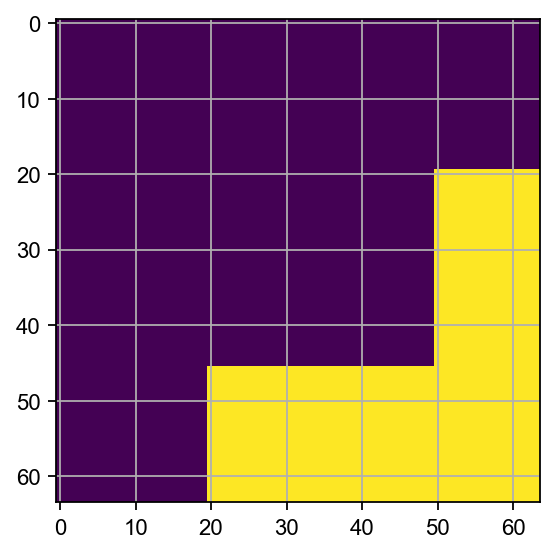

In [50]:
Gtarget = np.zeros((64,64))

# Gtarget[20:20+G_conv_ecc.shape[0], 20:20+G_conv_ecc.shape[1]] = G_conv_ecc

Msel = np.zeros((64,64))
Msel[20:,20:] = 1

Msel[20:20+G_conv_ecc.shape[0], 20:20+G_conv_ecc.shape[1]] = 0
plt.imshow(Msel)

In [51]:
data = dpe.tune_conductance(0,  Gtarget, saveHistory=True, maxSteps=300, method='slow',
                           vSetRamp=[1, 3, 0.25], vGateSetRamp=[0.5, 1.4, 0.05],
                           vResetRamp=[0.3, 2.2, 0.05], vGateResetRamp=[5.0, 5.5, 0.5], 
                           Twidth=10e-6, TwidthReset=10e-3,  Msel=Msel, Gtol_in=5e-6, Gtol_out=20e-6, numReads=3)

Start programming, step=93, maxBound=0 yield= 97.75% - 99.91%
1.0 devices to be programmed...reset 1.0, set 0.0
Setting 0 devices...
Programming with external timing Twidth=10.000 us
Resetting 1 devices...
Programming with external timing Twidth=10000.000 us
......------------------------------
Programming completed.


## CNN test

In [175]:
i = 0

for img, lab in tqdm(zip(test_images, test_labels), total=10000):
    i += 1

    vectors = nn._conv_flattern(img)
    
    output = dpe.multiply(
            0, 
            vectors, 
            c_sel=[20, 50], 
            r_start=20, mode=0, Tdly=500) / (nn.Gratio)
    
    print(vectors.shape)
    break

(26, 400)



In [176]:
output_soft = vectors.T @ G_conv_ecc / nn.Gratio

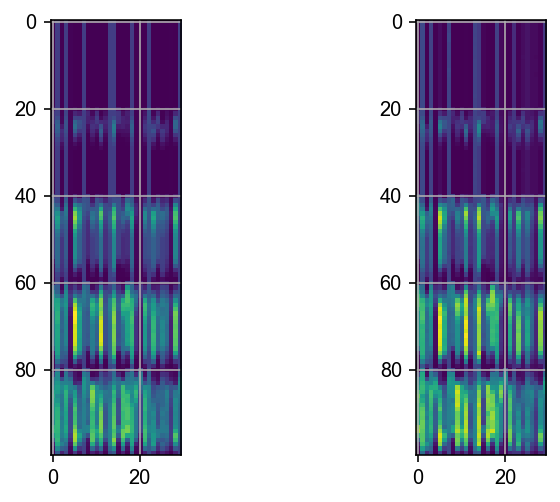

In [177]:
plt.subplot(121)
plt.imshow(output_soft[:100])

plt.subplot(122)
plt.imshow(output[:100])

Core output

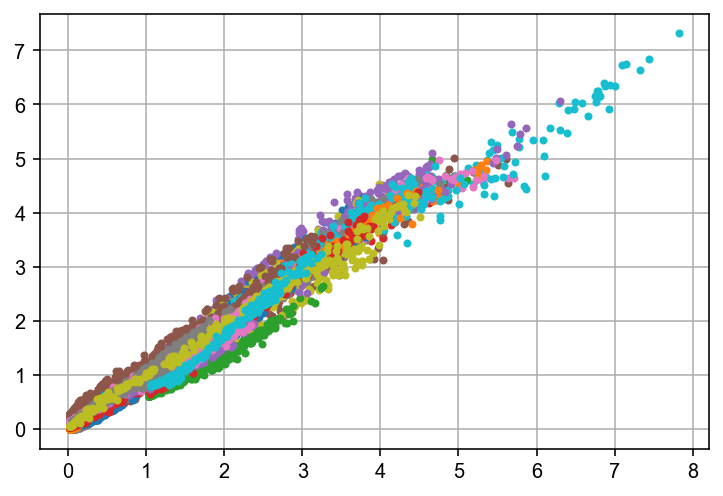

In [178]:
for c in range(output.shape[1]):
    plt.plot(output_soft[:,c], output[:,c], '.')

Linear correction

In [179]:
lin_cor_conv = []
for c in range(output.shape[1]):
    lin_cor_conv.append( np.polyfit(output[:,c], output_soft[:,c], 1))

In [180]:
output_cor = dpe.lin_corr(output, lin_cor_conv)

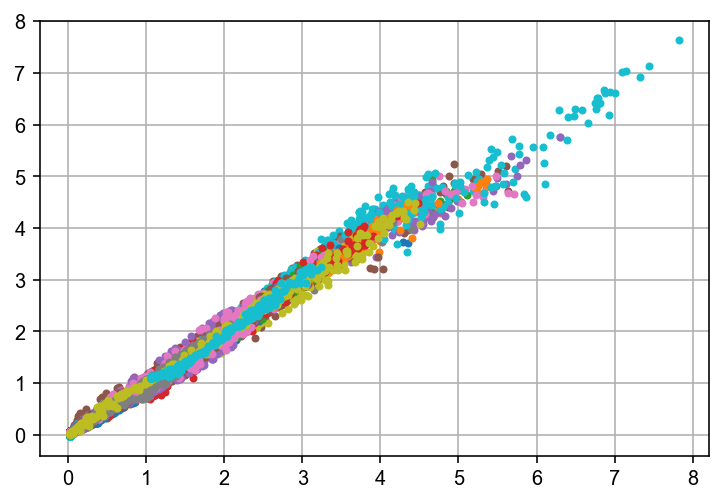

In [181]:
for c in range(output.shape[1]):
    plt.plot(output_soft[:,c], output_cor[:,c], '.')

Text(0.5, 0, 'Output error')

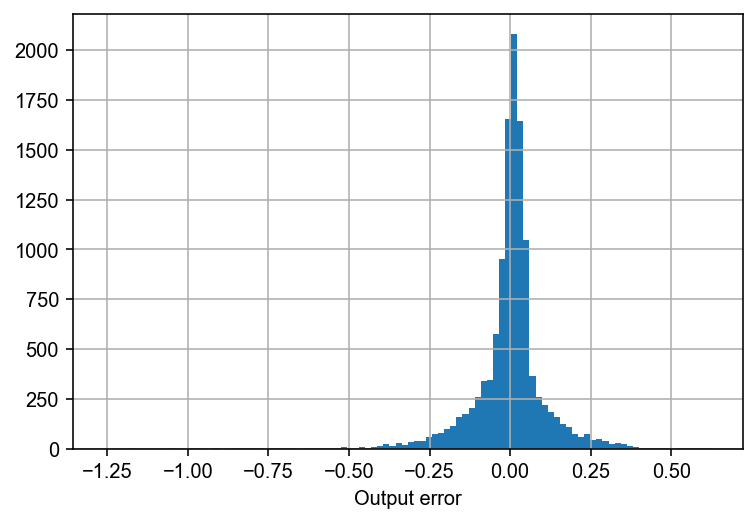

In [182]:
_ = plt.hist((output_cor - output_soft ).reshape(-1), 100)
plt.xlabel('Output error')

## Try ECC

In [77]:
delta = 0.2
Delta = 8 * delta

m = nn.Mconv.shape[0]
k = nn.Mconv.shape[1]

ecc = dpeECC(nn.Mconv, delta, Delta)

In [54]:
i = 0

n_detected = 0
n_corrected = 0
n_other = 0

y_pred = []

N_IMG = 100

for img, lab in tqdm(zip(test_images, test_labels), total=N_IMG):
    i += 1

    vectors = nn._conv_flattern(img)
    
    # HARDWARE CALL
    output = dpe.multiply(
            0, 
            vectors, 
            c_sel=[20, 50], 
            r_start=20, mode=0, Tdly=500) / (nn.Gratio)
    
    # Linear correction
    output = dpe.lin_corr(output, lin_cor_conv)
    
    y1 = output[:, ::2] - output[:, 1::2]
    
    # ECC
    S = (y1 @ G_parity_ecc / nn.Gratio)
    S = S[:, ::2] - S[:, 1::2]

    for s, yy in zip(S, y1):
        ecc_loc, ecc_range = ecc.decode_w_syndrome(s)
        
        if ecc_loc != -1:
            if ecc_loc == -2:
                # Detected but could not be corrected
                n_detected += 1
                
            elif ecc_loc >=0:
                # Correct
                n_corrected += 1
                yy[ecc_loc] -= (ecc_range[0]+ecc_range[1])/2
            else:
                n_other += 1
    
    k = nn.Gconv.shape[1] //2
    
    x = y1[:, :k]

    x = x.reshape(20, 20, -1)

    x1 = nn.relu(x)
    x1 = nn.max_pooling(x1)
    x1 = nn.flattern(x1)
    x1 = np.append(x1, 1)


    y = x1.T @ finalGfc
    y = y[::2] - y[1::2]

    y_pred.append(y.argmax())
    
    if i>= N_IMG:
        break

In [55]:
n_detected, n_corrected, n_other

(4646, 5975, 0)

In [56]:
np.mean(y_pred == test_labels[:N_IMG])

0.99

## Without ECC

In [57]:
i = 0

n_detected = 0
n_corrected = 0
n_other = 0

y_pred = []

N_IMG = 100

for img, lab in tqdm(zip(test_images, test_labels), total=N_IMG):
    i += 1

    vectors = nn._conv_flattern(img)
    
    # HARDWARE CALL
    output = dpe.multiply(
            0, 
            vectors, 
            c_sel=[20, 50], 
            r_start=20, mode=0, Tdly=500) / (nn.Gratio)
    
    # Linear correction
    output = dpe.lin_corr(output, lin_cor_conv)
    
    y1 = output[:, ::2] - output[:, 1::2]
    
#     # ECC
#     S = (y1 @ G_parity_ecc / nn.Gratio)
#     S = S[:, ::2] - S[:, 1::2]

#     for s, yy in zip(S, y1):
#         ecc_loc, ecc_range = ecc.decode_w_syndrome(s)
        
#         if ecc_loc != -1:
#             if ecc_loc == -2:
#                 # Detected but could not be corrected
#                 n_detected += 1
                
#             elif ecc_loc >=0:
#                 # Correct
#                 n_corrected += 1
#                 yy[ecc_loc] -= (ecc_range[0]+ecc_range[1])/2
#             else:
#                 n_other += 1
    
    k = nn.Gconv.shape[1] //2
    
    x = y1[:, :k]

    x = x.reshape(20, 20, -1)

    x1 = nn.relu(x)
    x1 = nn.max_pooling(x1)
    x1 = nn.flattern(x1)
    x1 = np.append(x1, 1)


    y = x1.T @ finalGfc
    y = y[::2] - y[1::2]

    y_pred.append(y.argmax())
    
    if i>= N_IMG:
        break

In [58]:
np.mean(y_pred == test_labels[:N_IMG])

0.98

## Plot the difference

In [191]:
delta = 0.2
Delta = 8 * delta

m = nn.Mconv.shape[0]
k = nn.Mconv.shape[1]

ecc = dpeECC(nn.Mconv, delta, Delta)

In [192]:
i = 0

n_detected = 0
n_corrected = 0
n_other = 0

y_pred = []

N_IMG = 1

for img, lab in tqdm(zip(test_images, test_labels), total=N_IMG):
    i += 1

    vectors = nn._conv_flattern(img)
    
    # HARDWARE CALL
    output = dpe.multiply(
            0, 
            vectors, 
            c_sel=[20, 50], 
            r_start=20, mode=0, Tdly=500) / (nn.Gratio)
    
    # Linear correction
    output = dpe.lin_corr(output, lin_cor_conv)
    
    y1 = output[:, ::2] - output[:, 1::2]
    
    y1_raw = y1.copy()
    
    # ECC
    S = (y1 @ G_parity_ecc / nn.Gratio)
    S = S[:, ::2] - S[:, 1::2]

    for s, yy in zip(S, y1):
        ecc_loc, ecc_range = ecc.decode_w_syndrome(s)
        
        if ecc_loc != -1:
            if ecc_loc == -2:
                # Detected but could not be corrected
                n_detected += 1
                
            elif ecc_loc >=0:
                # Correct
                n_corrected += 1
                yy[ecc_loc] -= (ecc_range[0]+ecc_range[1])/2
            else:
                n_other += 1
    
    k = nn.Gconv.shape[1] //2
    
    x = y1[:, :k]

    x = x.reshape(20, 20, -1)

    x1 = nn.relu(x)
    x1 = nn.max_pooling(x1)
    x1 = nn.flattern(x1)
    x1 = np.append(x1, 1)


    y = x1.T @ finalGfc
    y = y[::2] - y[1::2]

    y_pred.append(y.argmax())
    
    if i>= N_IMG:
        break

In [193]:
output_soft = vectors.T @ G_conv_ecc / nn.Gratio
y1_soft = output_soft[:, ::2] - output_soft[:, 1::2]

In [194]:
n_detected, n_corrected, n_other

(28, 22, 0)

Text(0.5, 0, 'Output error')

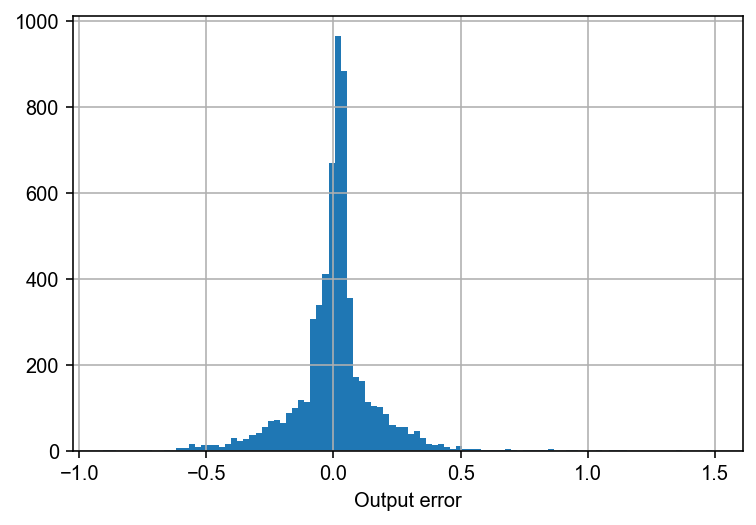

In [195]:
_ = plt.hist((y1_raw - y1_soft ).reshape(-1), 100)
plt.xlabel('Output error')

Text(0.5, 0, 'Output error')

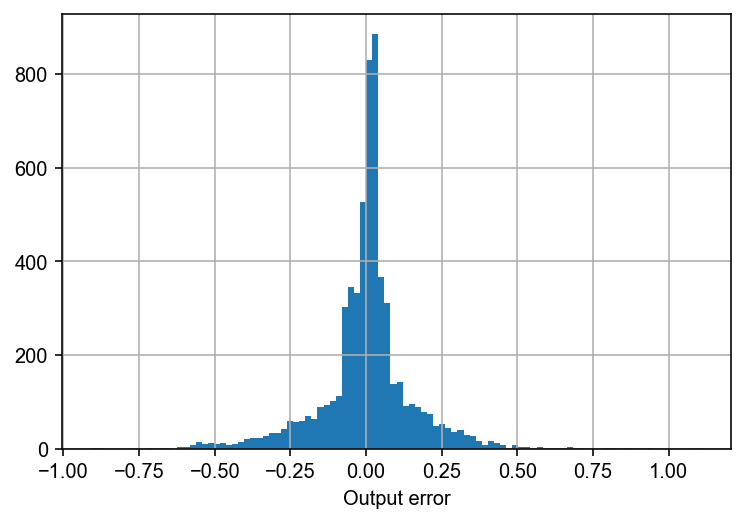

In [196]:
_ = plt.hist((y1 - y1_soft ).reshape(-1), 100)
plt.xlabel('Output error')

In [197]:
err_raw = (y1_raw - y1_soft).reshape(-1)

np.std(err_raw)

0.1601212118661271

In [198]:
err_ecc = (y1 - y1_soft).reshape(-1)

np.std(err_ecc)

0.15387349007121212

Text(0, 0.5, 'Cummulative number of error')

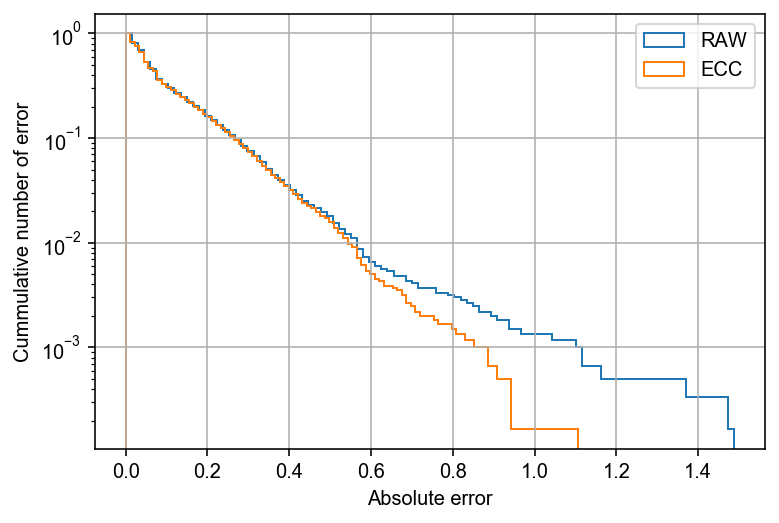

In [199]:
_ = plt.hist(abs(err_raw), density=True, histtype='step', cumulative=-1,
        label='RAW', bins=100)

_ = plt.hist(abs(err_ecc), density=True, histtype='step', cumulative=-1,
        label='ECC', bins=100)

plt.legend()

plt.yscale('log')

plt.xlabel('Absolute error')
plt.ylabel('Cummulative number of error')

## Explore delta parameter

In [200]:
delta_list = np.arange(0.1, 0.5, 0.02)

y1_raw_list = []
y1_list = []

for delta in tqdm(delta_list):

    Delta = 8 * delta

    ecc = dpeECC(nn.Mconv, delta, Delta)

    img = test_images[0]


    vectors = nn._conv_flattern(img)

    # HARDWARE CALL
    output = dpe.multiply(
            0, 
            vectors, 
            c_sel=[20, 50], 
            r_start=20, mode=0, Tdly=500) / (nn.Gratio)

    # Linear correction
    output = dpe.lin_corr(output, lin_cor_conv)

    y1 = output[:, ::2] - output[:, 1::2]

    y1_raw = y1.copy()

    # ECC
    S = (y1 @ G_parity_ecc / nn.Gratio)
    S = S[:, ::2] - S[:, 1::2]

    for s, yy in zip(S, y1):
        ecc_loc, ecc_range = ecc.decode_w_syndrome(s)

        if ecc_loc != -1:
            if ecc_loc == -2:
                # Detected but could not be corrected
                n_detected += 1

            elif ecc_loc >=0:
                # Correct
                n_corrected += 1
                yy[ecc_loc] -= (ecc_range[0]+ecc_range[1])/2
            else:
                n_other += 1
                
    y1_raw_list.append(y1_raw)
    y1_list.append(y1)

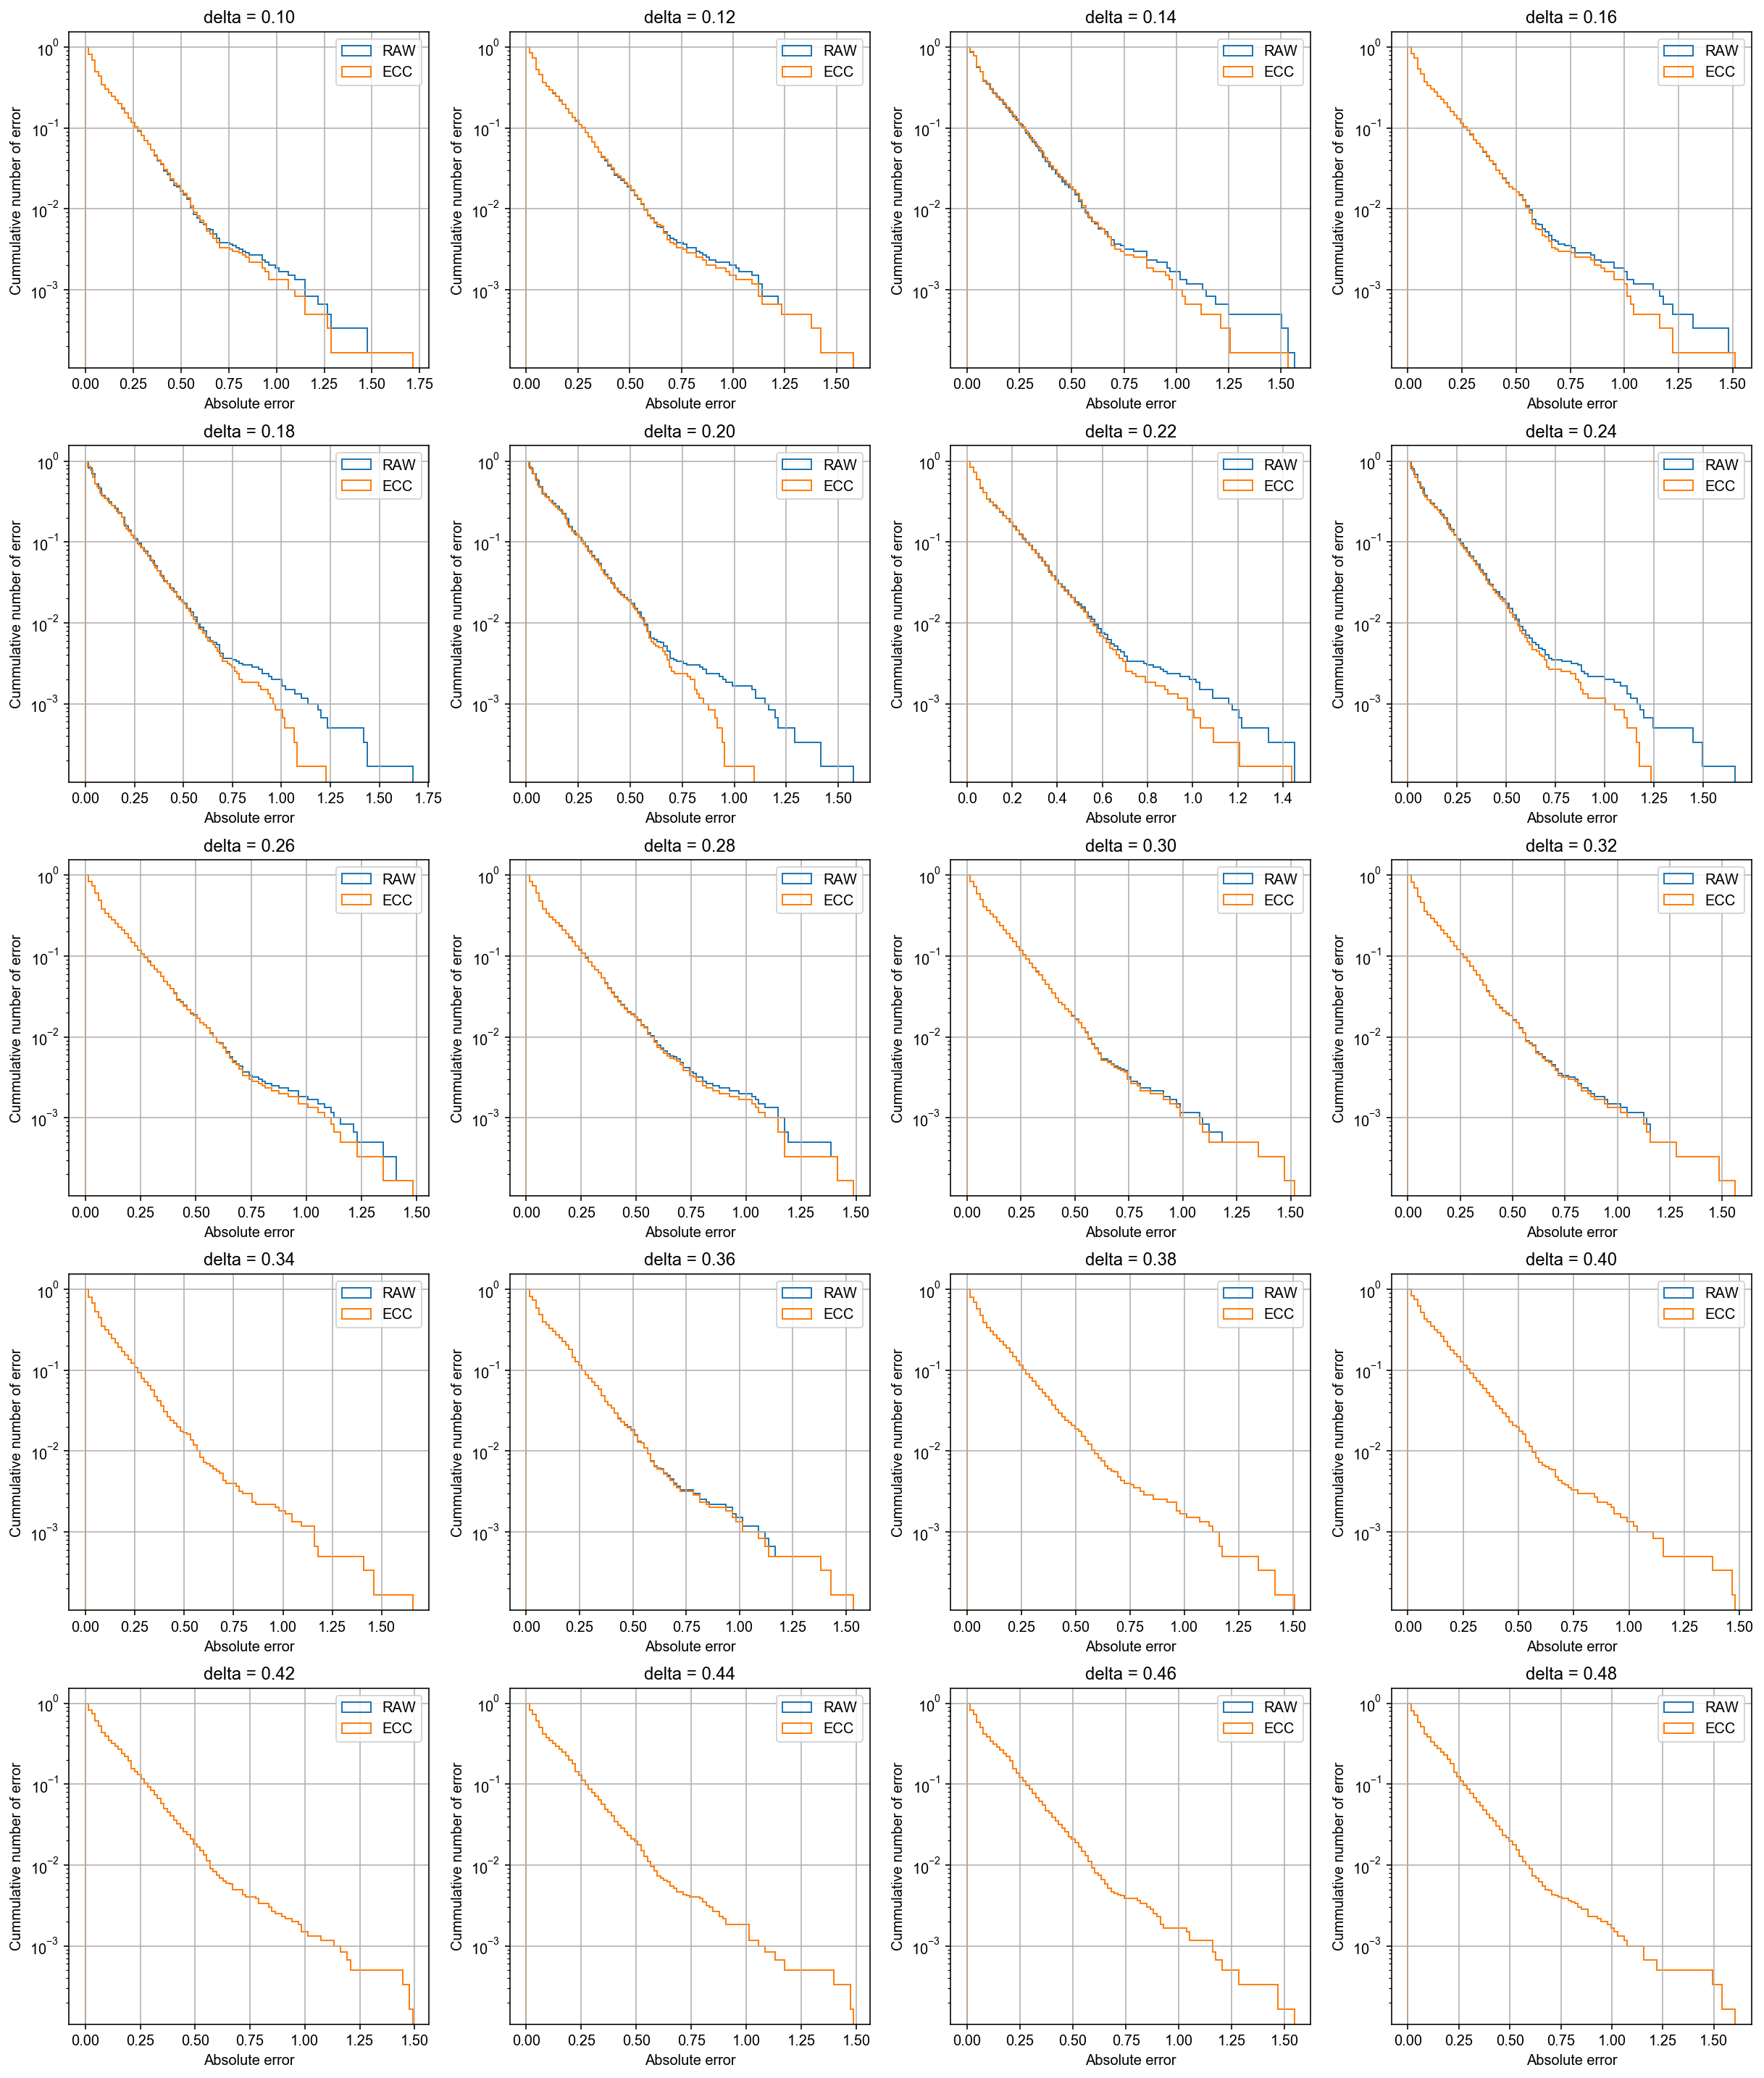

In [201]:
plt.figure(figsize=(17,20))

for i in range(len(y1_list)):
    
    plt.subplot(5,4,i+1)

    y1_raw = y1_raw_list[i]
    y1 = y1_list[i]


    err_raw = (y1_raw - y1_soft).reshape(-1)
    err_ecc = (y1 - y1_soft).reshape(-1)


    _ = plt.hist(abs(err_raw), density=True, histtype='step', cumulative=-1,
            label='RAW', bins=100)

    _ = plt.hist(abs(err_ecc), density=True, histtype='step', cumulative=-1,
            label='ECC', bins=100)

    plt.legend()

    plt.yscale('log')

    plt.xlabel('Absolute error')
    plt.ylabel('Cummulative number of error')
    
    plt.title(f'delta = {delta_list[i]:.2f}')
    
plt.tight_layout()

## Re-read the transient error

In [204]:
from copy import deepcopy

N_READ = 2

delta_list = np.arange(0.1, 0.5, 0.02)

y1_raw_list = []
y1_list = []
y2_list = []

for delta in tqdm(delta_list):

    Delta = 8 * delta

    ecc = dpeECC(nn.Mconv, delta, Delta)
    
    img = test_images[0]

    vectors = nn._conv_flattern(img)
    
    # HARDWARE CALL
    output = dpe.multiply(
            0, 
            vectors, 
            c_sel=[20, 50], 
            r_start=20, mode=0, Tdly=500) / (nn.Gratio)

    # Linear correction
    output = dpe.lin_corr(output, lin_cor_conv)

    y1 = output[:, ::2] - output[:, 1::2]

    #### RECORD RAW ####
    y1_raw_list.append(deepcopy(y1))

    # ECC
    S = (y1 @ G_parity_ecc / nn.Gratio)
    S = S[:, ::2] - S[:, 1::2]
    
    row_error = np.zeros(y1.shape[0])
    row_error_list = []

    for r, (s, yy) in enumerate(zip(S, y1)):
        ecc_loc, ecc_range = ecc.decode_w_syndrome(s)

        if ecc_loc != -1:
            if ecc_loc == -2:
                # Detected but could not be corrected
                n_detected += 1
                
                row_error[r] = 1
                row_error_list.append(r)

            elif ecc_loc >=0:
                # Correct
                n_corrected += 1
                yy[ecc_loc] -= (ecc_range[0]+ecc_range[1])/2
            else:
                n_other += 1
     
    #### RECORD ECC1 ####
    y1_list.append(deepcopy(y1))
    
    # Read again
    output = dpe.multiply(
            0, 
            vectors[:,row_error==1], 
            c_sel=[20, 50], 
            r_start=20, mode=0, Tdly=500) / (nn.Gratio)
    
    output = dpe.lin_corr(output, lin_cor_conv)
    y2 = output[:, ::2] - output[:, 1::2]
    
    S = (y2 @ G_parity_ecc / nn.Gratio)
    S = S[:, ::2] - S[:, 1::2]
    
    for r, (s, yy) in enumerate(zip(S, y2)):
        ecc_loc, ecc_range = ecc.decode_w_syndrome(s)

        if ecc_loc != -1:
            if ecc_loc == -2:
                # Detected but could not be corrected
                n_detected += 1
                
                row_error[r] = 1
                print(f'row={r}, double error')

            elif ecc_loc >=0:
                # Correct
                n_corrected += 1
                yy[ecc_loc] -= (ecc_range[0]+ecc_range[1])/2
                
                y1[row_error_list[r]] = yy
                print(f'row={r}, corrected')
            else:
                n_other += 1
        else:
            y1[row_error_list[r]] = yy
            print(f'row={r}, second read correct')
                     
    #### RECORD ECC2 ####
    y2_list.append(deepcopy(y1))

row=0, double error
row=1, double error
row=2, double error
row=3, double error
row=4, corrected
row=5, double error
row=6, double error
row=7, double error
row=8, corrected
row=9, corrected
row=10, double error
row=11, double error
row=12, double error
row=13, double error
row=14, second read correct
row=15, second read correct
row=16, double error
row=17, double error
row=18, double error
row=19, corrected
row=20, double error
row=21, double error
row=22, double error
row=23, double error
row=24, second read correct
row=25, second read correct
row=26, second read correct
row=27, corrected
row=28, double error
row=29, corrected
row=30, double error
row=31, double error
row=32, double error
row=33, double error
row=34, double error
row=35, corrected
row=36, second read correct
row=37, corrected
row=38, double error
row=39, second read correct
row=40, corrected
row=41, corrected
row=42, double error
row=43, second read correct
row=44, corrected
row=45, double error
row=46, corrected
row

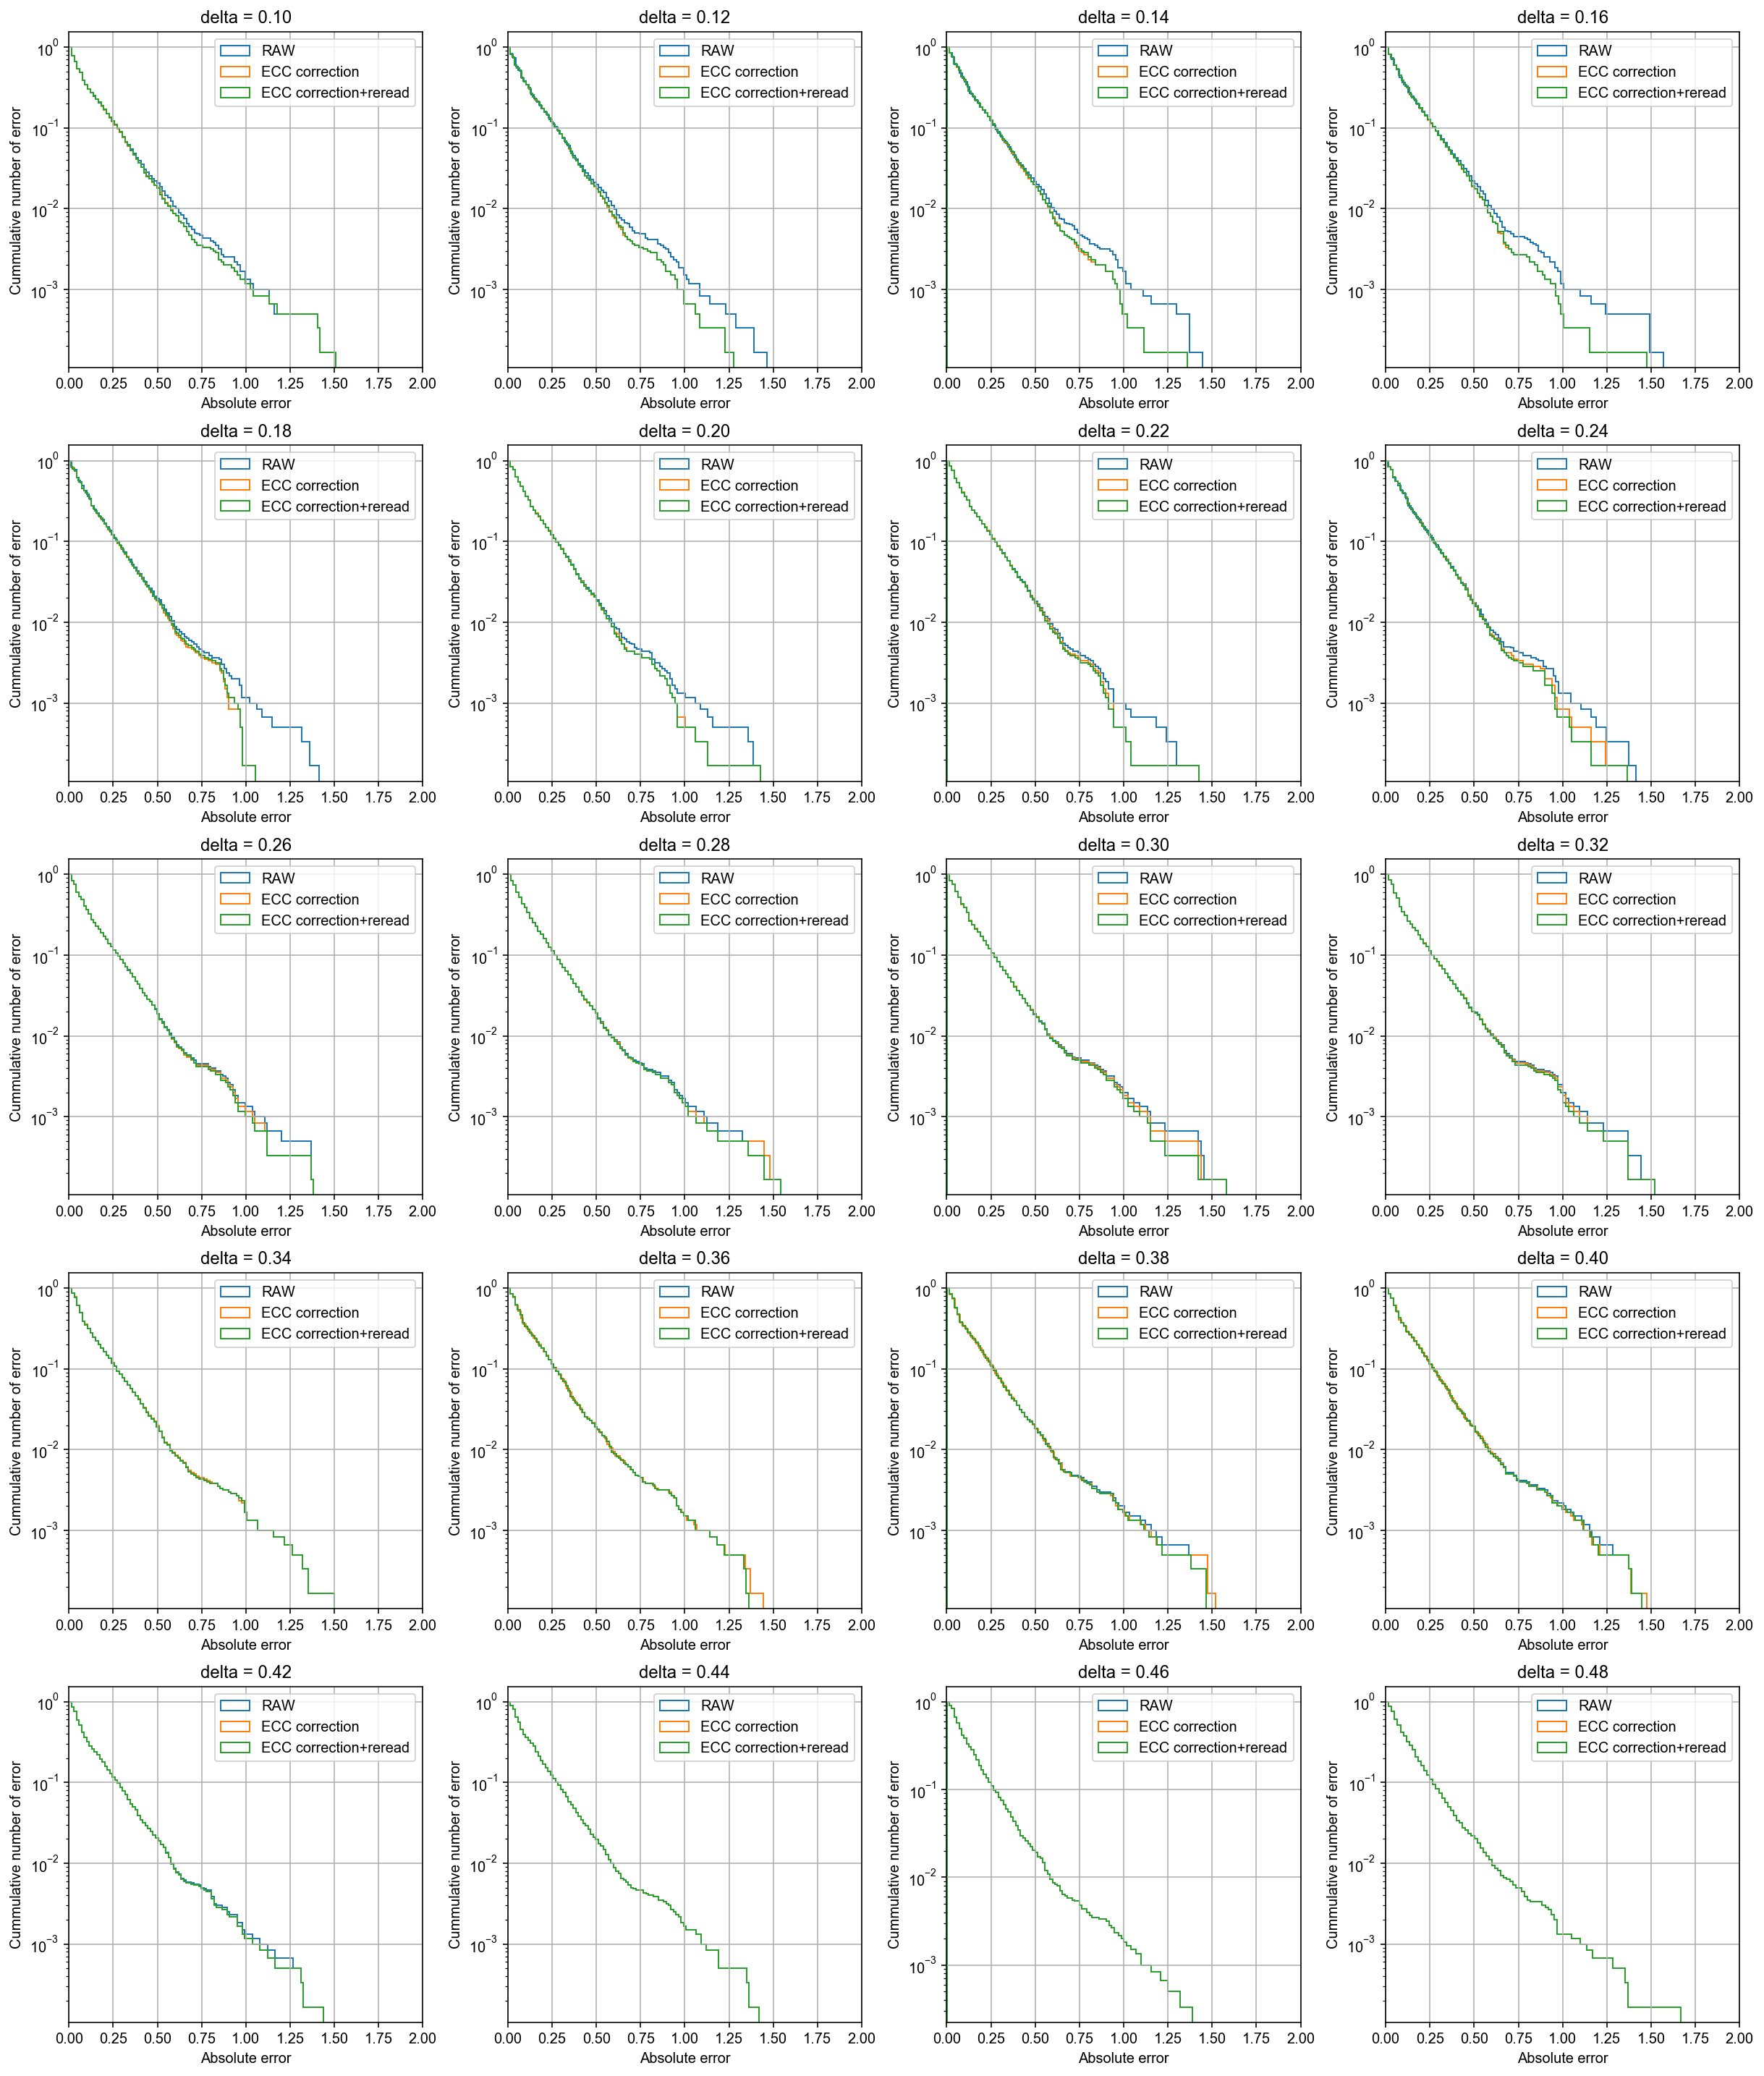

In [205]:
output_soft = vectors.T @ G_conv_ecc / nn.Gratio
y1_soft = output_soft[:, ::2] - output_soft[:, 1::2]

plt.figure(figsize=(17,20))

for i in range(len(y1_list)):
    
    plt.subplot(5,4,i+1)
    

    y1_raw = y1_raw_list[i]
    y1 = y1_list[i]
    y2 = y2_list[i]


    err_raw = (y1_raw - y1_soft).reshape(-1)
    err_ecc = (y1 - y1_soft).reshape(-1)
    err_ecc2 = (y2 - y1_soft).reshape(-1)


    _ = plt.hist(abs(err_raw), density=True, histtype='step', cumulative=-1,
            label='RAW', bins=100)

    _ = plt.hist(abs(err_ecc), density=True, histtype='step', cumulative=-1,
            label='ECC correction', bins=100)
    
    _ = plt.hist(abs(err_ecc2), density=True, histtype='step', cumulative=-1,
            label='ECC correction+reread', bins=100)

    plt.legend()

    plt.yscale('log')
    plt.xlim((0,2))

    plt.xlabel('Absolute error')
    plt.ylabel('Cummulative number of error')
    
    plt.title(f'delta = {delta_list[i]:.2f}')
    
plt.tight_layout()